# DDPM Bird Defense Implementation

In [38]:
from dataclasses import dataclass
from torch.utils.data import random_split, Dataset, DataLoader
from datasets import load_dataset
from birdclassifier import BirdDataset
import matplotlib.pyplot as plt
from torchvision import transforms
from diffusers import UNet2DModel
from diffusers.optimization import get_cosine_schedule_with_warmup
import safetensors.torch

import torch
import torch.nn.functional as F
from PIL import Image
from diffusers import DDPMScheduler, DDPMPipeline
import math

from accelerate import Accelerator, notebook_launcher
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path
import os
import glob

device = "cuda" if torch.cuda.is_available() else "cpu"

## Define the Train Config

In [39]:
@dataclass
class TrainingConfig:
    image_size = 224  # the generated image resolution
    train_batch_size = 8
    eval_batch_size = 8  # how many images to sample during evaluation
    num_epochs = 200
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "bird-data-defense-ddpm"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

## Define the Data

In [40]:
dataset = BirdDataset("./bird-data", "test")
dl = DataLoader(dataset, batch_size = config.train_batch_size, shuffle = True, num_workers = 4)

## Plot Data Before Training

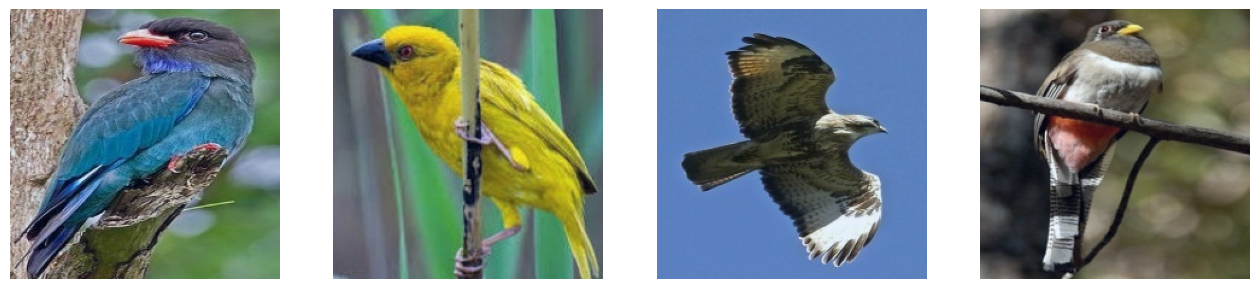

In [41]:
def plot_bird_data(n):
    fig, axs = plt.subplots(1, n, figsize=(16, 4))
    images = []
    for batch in dl:
        ims, labels = batch[0], batch[1]
        for i, im in enumerate(ims):
            im = im - im.min()  # Translate pixel values to start from 0
            im = im / im.max()  # Scale pixel values to [0, 1]
            im = im.permute(1, 2, 0)

            axs[i].imshow(im)
            axs[i].set_axis_off()
            
            images.append(im)
            if i > n - 2:
                break
        break

    return images

basic_images = plot_bird_data(4)

### More Plot Functions

In [42]:
def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid


def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

## Define the UNet2D Model

In [43]:
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

### Verify the shape of the data
for batch in dl:
    images, labels = batch[0], batch[1]
    sample_image = images[0].unsqueeze(0)
    print("Input shape:", sample_image.shape)

    print("Output shape:", model(sample_image, timestep=0).sample.shape)
    break

Input shape: torch.Size([1, 3, 224, 224])


Output shape: torch.Size([1, 3, 224, 224])


## Create a Scheduler

tensor(1.1519, grad_fn=<MseLossBackward0>)


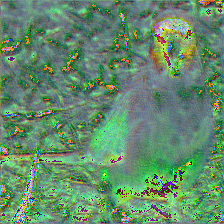

In [44]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(dl) * config.num_epochs),
)

Image.fromarray(((noise_pred.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

## Training Loop

In [45]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch[0]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir)

In [46]:

args = (config, model, noise_scheduler, optimizer, dl, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

/home/grads/hassledw/miniconda3/envs/genai/lib/python3.11/site-packages/accelerate/accelerator.py:387: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")


Launching training on CPU.


Epoch 0:   0%|          | 0/2645 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Image Restoration

torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])


KeyboardInterrupt: 

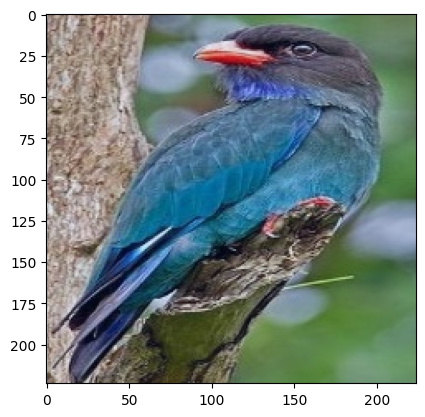

In [60]:
def visualizable_image(reverse_input):
    input_visualizable = reverse_input.permute(0, 2, 3, 1)

    # Step 2: Remove the batch dimension
    input_visualizable = input_visualizable.squeeze(0)

    # If `input_visualizable` tensor is in a float format with values in [0, 1] (common for models),
    # you might need to scale it to [0, 255] and convert to an integer format for proper visualization.
    if input_visualizable.is_floating_point():
        input_visualizable = (input_visualizable * 255).byte()

    # Convert to NumPy array for visualization if necessary
    input_visualizable = input_visualizable.cpu().numpy()
    return input_visualizable


with open('./bird-data-defense-ddpm/unet/diffusion_pytorch_model.safetensors', 'rb') as f:
    model_bytes = f.read()
    
model_weights = safetensors.torch.load(model_bytes)
model = UNet2DModel.from_config("./bird-data-defense-ddpm/unet/config.json")
model.load_state_dict(model_weights)

model.eval()  # Set the model to evaluation mode

# Run Forward:
start_img = basic_images[0]
plt.imshow(start_img)
noise = torch.randn(start_img.shape)
timesteps = torch.LongTensor([999])
noisy_image = noise_scheduler.add_noise(start_img, noise, timesteps)

print(start_img.shape)
print(noise.shape)
print(noisy_image.shape)
# Run Reverse:
reverse_input = noisy_image.unsqueeze(0).permute(0, 3, 1, 2)

for t in noise_scheduler.timesteps:
    with torch.no_grad():
        model_output = model(reverse_input, torch.tensor([t], device=reverse_input.device))
        noisy_residual = model_output.sample
        reverse_input = noise_scheduler.step(noisy_residual, t, reverse_input).prev_sample
        
        if t % 100 == 0:
            plt.imsave(f"./bird-data-defense-ddpm/samples/test-bird/test-bird-{t}.png", visualizable_image(reverse_input))
# The restored_image tensor now contains the restored image
    

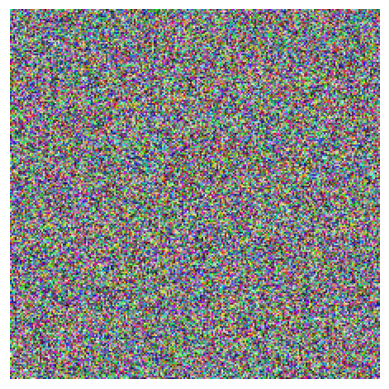

In [54]:
# Step 1: Permute the dimensions back to [batch_size, height, width, channels]
input_visualizable = reverse_input.permute(0, 2, 3, 1)

# Step 2: Remove the batch dimension
input_visualizable = input_visualizable.squeeze(0)

# If `input_visualizable` tensor is in a float format with values in [0, 1] (common for models),
# you might need to scale it to [0, 255] and convert to an integer format for proper visualization.
if input_visualizable.is_floating_point():
    input_visualizable = (input_visualizable * 255).byte()

# Convert to NumPy array for visualization if necessary
input_visualizable = input_visualizable.cpu().numpy()

# Now `input_visualizable` is ready for visualization with matplotlib or similar
import matplotlib.pyplot as plt

plt.imshow(input_visualizable)
plt.axis('off')  # Optional: Remove axes for better visualization
plt.show()